In [29]:
from pathlib import Path
import numpy as np
import random

WINDOW_DIR = Path("../data/processed/sisfall/tsad/windows")

sample_file = random.choice(list(WINDOW_DIR.glob("*.npz")))
sample_file = WINDOW_DIR / "F08_SA03_R01.npz"  # Specific file for demonstration

data = np.load(sample_file, allow_pickle=True)
X, y, meta = data["X"], data["y"], data["meta"].item()

print("File:", sample_file.name)
print("X shape:", X.shape)   # (num_windows, window_size, num_channels)
print("y shape:", y.shape)
print("Meta:", meta)
print("Fall windows:", sum(y), "/", len(y))

File: F08_SA03_R01.npz
X shape: (28, 200, 6)
y shape: (28,)
Meta: {'activity': 'F08', 'subject': 'SA03', 'group': 'young', 'trial': 'R01', 'is_fall': 1}
Fall windows: 3 / 28


In [21]:
from pathlib import Path
import numpy as np
import pandas as pd

# -- Sensor characteristics from Readme.txt --
# ADXL345 (Accelerometer 1)
ADXL345_RESOLUTION = 13
ADXL345_RANGE = 16  # +-16g

# ITG3200 (Gyroscope)
ITG3200_RESOLUTION = 16
ITG3200_RANGE = 2000  # +-2000 deg/s

# MMA8451Q (Accelerometer 2)
MMA8451Q_RESOLUTION = 14
MMA8451Q_RANGE = 8  # +-8g

# -- Conversion formulas --
# Acceleration [g]: [(2*Range)/(2^Resolution)]*AD
# Angular velocity [deg/s]: [(2*Range)/(2^Resolution)]*RD

ADXL345_CONVERSION_FACTOR = (2 * ADXL345_RANGE) / (2**ADXL345_RESOLUTION)
ITG3200_CONVERSION_FACTOR = (2 * ITG3200_RANGE) / (2**ITG3200_RESOLUTION)
MMA8451Q_CONVERSION_FACTOR = (2 * MMA8451Q_RANGE) / (2**MMA8451Q_RESOLUTION)

ACC_1_SLICE = slice(0, 3)  # x, y, z for ADXL345
GYR_SLICE = slice(3, 6)  # x, y, z for ITG3200
ACC_2_SLICE = slice(6, 9)  # x, y, z for MMA8451Q 

def load_signal(file_path: Path) -> np.ndarray:
    """
    Read a SisFall data file into a numpy array and convert raw bit values
    to physical units (g for accelerometer, deg/s for gyroscope).
    """
    df = pd.read_csv(file_path, sep=",", header=None)

    # The last column might contain a trailing semicolon. 
    # Check if the last column is of object type (string) before applying .str accessor to remove the semicolon.
    if df.iloc[:, -1].dtype == 'object':
        df.iloc[:, -1] = df.iloc[:, -1].str.replace(';', '', regex=False)

    arr = df.to_numpy(dtype=np.float32) # Convert all data to float32 numpy array
    if arr.shape[1] < 9:
        raise ValueError(f"Data file {file_path} has less than 9 columns.")
    
    # Separate sensor data
    accel_1_data = arr[:, ACC_1_SLICE]
    gyro_data = arr[:, GYR_SLICE]
    accel_2_data = arr[:, ACC_2_SLICE]

    # Apply unit conversion
    accel_1_data_g = accel_1_data * ADXL345_CONVERSION_FACTOR
    gyro_data_degs = gyro_data * ITG3200_CONVERSION_FACTOR
    accel_2_data_g = accel_2_data * MMA8451Q_CONVERSION_FACTOR

    return {
        "acc1": accel_1_data_g,
        "gyr": gyro_data_degs,
        # "acc2": accel_2_data_g
    }

In [22]:
from scipy.signal import butter, filtfilt
# ----- Low-pass filter ----- 
def butter_lowpass_filter(data, cutoff=5, fs=200, order=4):
    b, a = butter(order, cutoff/(fs/2), btype='low', analog=False)
    return filtfilt(b, a, data, axis=0)

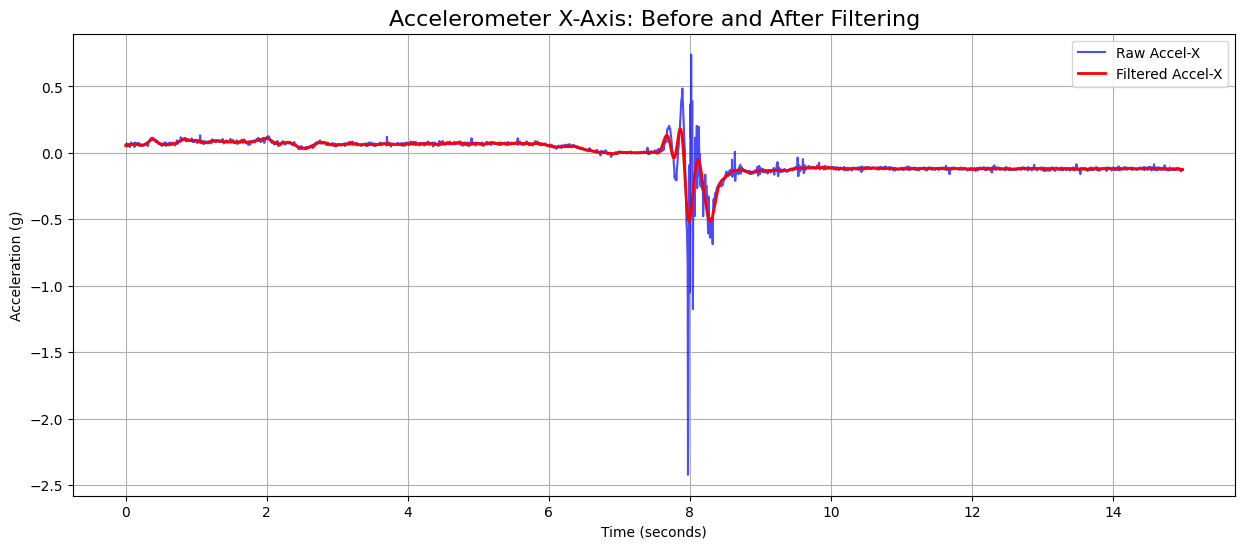

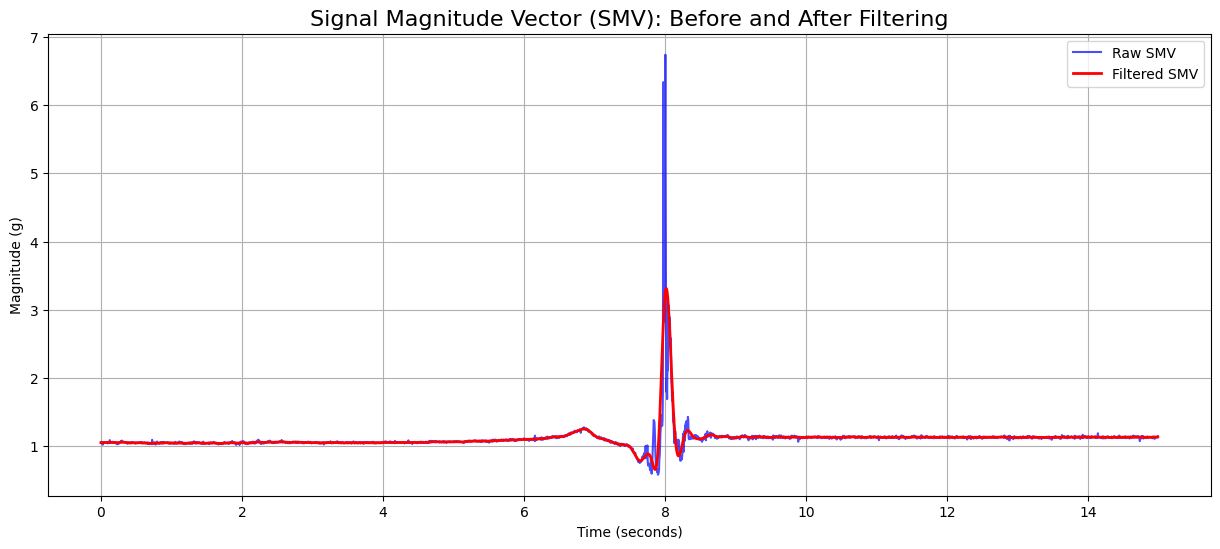

In [31]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# This is a common pattern in notebooks
if '../' not in sys.path:
    sys.path.append('../')

# from src.preprocessing.sisfall.tsad.load_signal import load_signal
# from src.preprocessing.sisfall.tsad.run_stage_1 import butter_lowpass_filter

# --- Configuration ---
FILE_TO_INSPECT = Path("../data/raw/sisfall/SA03/F08_SA03_R01.txt")

# --- 1. Load the Data ---
signals = load_signal(FILE_TO_INSPECT)
acc1_raw = signals['acc1']

# --- 2. Calculate SMV from Raw Data ---
smv_raw = np.sqrt(np.sum(acc1_raw**2, axis=1))

# --- 3. Apply the Filter ---
acc1_filtered = butter_lowpass_filter(acc1_raw)
smv_filtered = butter_lowpass_filter(smv_raw.reshape(-1, 1)).flatten()

# --- 4. Create the Plots ---
time_axis = np.arange(len(acc1_raw)) / 200.0  # Assuming a 200 Hz sampling rate

# Plot 1: Raw Accelerometer vs. Filtered Accelerometer (X-axis)
plt.figure(figsize=(15, 6))
plt.title("Accelerometer X-Axis: Before and After Filtering", fontsize=16)
plt.plot(time_axis, acc1_raw[:, 0], label='Raw Accel-X', color='blue', alpha=0.7)
plt.plot(time_axis, acc1_filtered[:, 0], label='Filtered Accel-X', color='red', linewidth=2)
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (g)")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Raw SMV vs. Filtered SMV
plt.figure(figsize=(15, 6))
plt.title("Signal Magnitude Vector (SMV): Before and After Filtering", fontsize=16)
plt.plot(time_axis, smv_raw, label='Raw SMV', color='blue', alpha=0.7)
plt.plot(time_axis, smv_filtered, label='Filtered SMV', color='red', linewidth=2)
plt.xlabel("Time (seconds)")
plt.ylabel("Magnitude (g)")
plt.legend()
plt.grid(True)
plt.show()



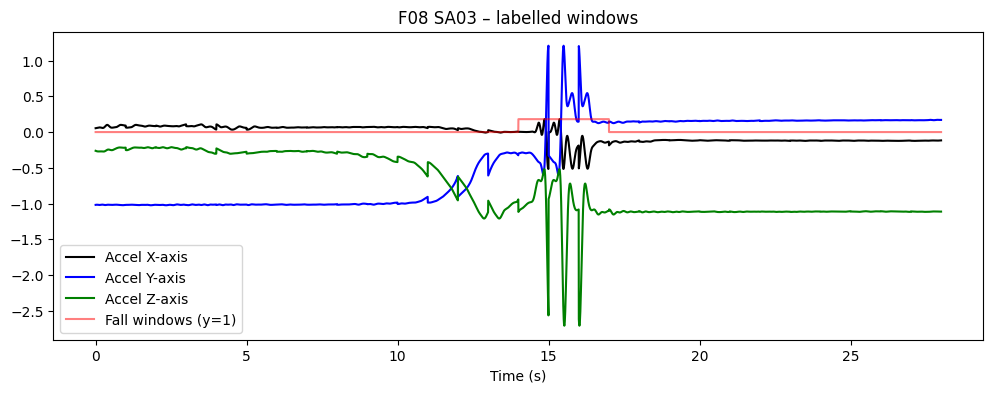

In [32]:
import matplotlib.pyplot as plt

# Flatten all windows back to 1D (just for visualization)
signal_x_flat = X.reshape(-1, X.shape[-1])[:,0]  # plot X-axis 
signal_y_flat = X.reshape(-1, X.shape[-1])[:,1]  # plot Y-axis 
signal_z_flat = X.reshape(-1, X.shape[-1])[:,2]  # plot Z-axis 
labels_flat = np.repeat(y, X.shape[1])

plt.figure(figsize=(12, 4))
# adjust the y scale from -2 to 2
# plt.ylim(-2, 2)

# adjust x axis to show time in seconds at 200hz, focusing on the middle part
time_axis = np.arange(len(signal_x_flat)) / 200

plt.xlabel("Time (s)")
plt.plot(time_axis, signal_x_flat, color="black", label="Accel X-axis")
plt.plot(time_axis, signal_y_flat, color="blue", label="Accel Y-axis")
plt.plot(time_axis, signal_z_flat, color="green", label="Accel Z-axis")
plt.plot(time_axis, labels_flat * signal_x_flat.max(), color="red", alpha=0.5, label="Fall windows (y=1)")

plt.title(f"{meta['activity']} {meta['subject']} – labelled windows")
plt.legend()
plt.show()


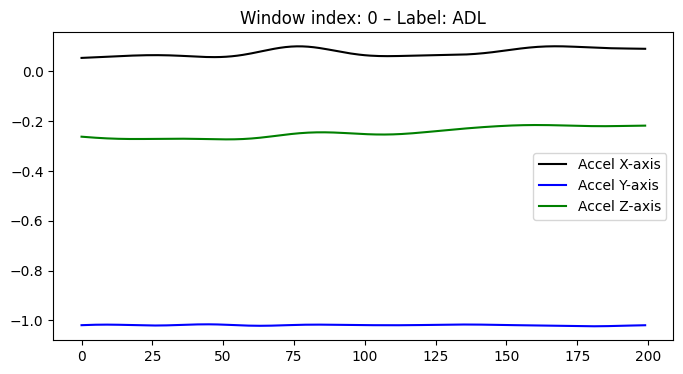

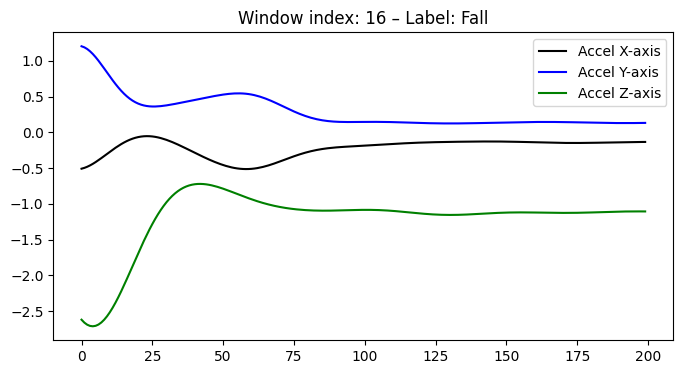

In [33]:
# Visualize an ADL and a Fall example
import matplotlib.pyplot as plt

def plot_window_example(X, y, index):
    window = X[index]
    label = y[index]
    
    plt.figure(figsize=(8, 4))
    plt.plot(window[:,0], label="Accel X-axis", color="black")
    plt.plot(window[:,1], label="Accel Y-axis", color="blue")
    plt.plot(window[:,2], label="Accel Z-axis", color="green")
    plt.title(f"Window index: {index} – Label: {'Fall' if label == 1 else 'ADL'}")
    plt.legend()
    plt.show()

# Find a random ADL example
adl_index = np.random.choice(np.where(y == 0)[0])
plot_window_example(X, y, adl_index)

# Find a random Fall example
fall_index = np.random.choice(np.where(y == 1)[0])
plot_window_example(X, y, fall_index)

In [34]:
from pathlib import Path
import numpy as np
import pandas as pd

records = []
for f in Path("../data/processed/sisfall/classification/windows").glob("*.npz"):
    d = np.load(f, allow_pickle=True)
    y = d["y"]
    meta = d["meta"].item()
    records.append({
        "file": f.name,
        "subject": meta["subject"],
        "activity": meta["activity"],
        "is_fall": meta["is_fall"],
        "num_windows": len(y),
        "num_fall_windows": sum(y)
    })

df = pd.DataFrame(records)
print(df.head())
print("\nTotal fall windows:", df["num_fall_windows"].sum())
print("Total ADL windows:", (df["num_windows"] - df["num_fall_windows"]).sum())

               file subject activity  is_fall  num_windows  num_fall_windows
0  F11_SA05_R01.npz    SA05      F11        1           28                 4
1  F01_SA04_R04.npz    SA04      F01        1           28                 4
2  F11_SA22_R02.npz    SA22      F11        1           28                 4
3  D15_SE04_R02.npz    SE04      D15        0           22                 0
4  D05_SE01_R04.npz    SE01      D05        0           48                 0

Total fall windows: 7174
Total ADL windows: 142218


<Axes: title={'center': 'Fall vs ADL window counts'}, xlabel='is_fall'>

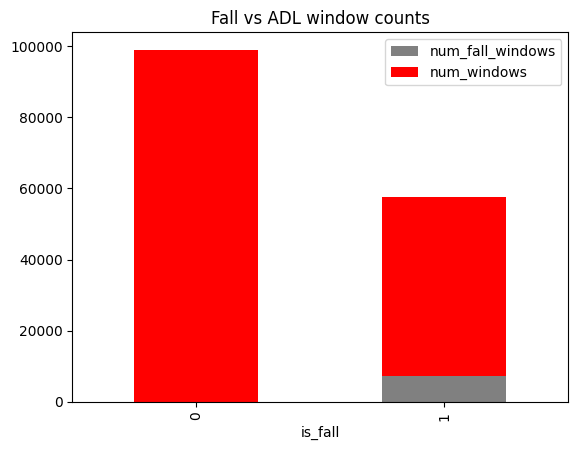

In [5]:
df.groupby("is_fall")[["num_fall_windows","num_windows"]].sum().plot(
    kind="bar", stacked=True, color=["gray", "red"], title="Fall vs ADL window counts"
)

In [35]:
fall_ratios = df[df["is_fall"]==1]["num_fall_windows"] / df[df["is_fall"]==1]["num_windows"]
print(f"Average fraction of fall-labelled windows: {fall_ratios.mean():.3f}")

Average fraction of fall-labelled windows: 0.142
